In [22]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic,CartesianRepresentation,CartesianDifferential
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('Set2')
%matplotlib inline

In [2]:
def get_uvw(age, kind='dwarf',z=None):
    #velocity paremeters
    
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307

    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430

    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445

    k = 74.
    sigma_u = v10*((age+tau1)/(10.+tau1))**beta
    sigma_v =  v10_v*((age+tau_v)/(10.+tau_v))**beta_v
    sigma_w =  v10_w*((age+tau_w)/(10.+tau_w))**beta_w

    voff = -1.*(sigma_v**2)/k
    
    us=np.random.normal(loc=0, scale=sigma_u, size=len(age))
    vs =np.random.normal(loc=voff, scale=sigma_v, size=len(age))
    ws =np.random.normal(loc=0.0, scale=sigma_w, size=len(age))
    
    if kind=='subdwarf':
        us=np.zeros(len(age))
        vs=np.zeros(len(age))
        ws=np.zeros(len(age))
        
        #0-4 kpc
        bools0=np.logical_and(np.abs(z) >=0, np.abs(z)>=4000)
        bools1=np.logical_and(np.abs(z) >4000, np.abs(z)>=8000)
        bools2=np.abs(z)>8000
        
        us[bools0]=np.random.normal(loc=-52+270, scale=-242 +270, size=len(z[bools0]))
        vs[bools0]=np.random.normal(loc=-242+270, scale=-103 +270, size=len(z[bools0]))
        ws[bools0]=np.random.normal(loc=0+270, scale=67 +270, size=len(z[bools0]))
        
        us[bools1]=np.random.normal(loc=-12+270, scale=131+270, size=len(z[bools1]))
        vs[bools1]=np.random.normal(loc=-282+270, scale=-111 +270, size=len(z[bools1]))
        ws[bools1]=np.random.normal(loc=-37+270, scale=85 +270, size=len(z[bools1]))
        
        us[bools2]=np.random.normal(loc=-1+270, scale=172+270, size=len(z[bools2]))
        vs[bools2]=np.random.normal(loc=-328+270, scale=-119 +270, size=len(z[bools2]))
        ws[bools2]=np.random.normal(loc=-32+270, scale=106 +270, size=len(z[bools2]))
        
    
    return us, vs, ws

In [3]:
#draw distances in random direction
H=350
FOV=0.28*(u.deg**2)
s=SkyCoord(l=90.0*u.deg, b=45*u.deg, frame='galactic')
p= popsims.Pointing(coord=s, name='wfirst0')

In [4]:
#get evolutionary models
baraffe=popsims.make_systems(model_name='baraffe2003')
subdrfs=popsims.make_systems(model_name='baraffe1998')
#age=baraffe['system_age']
#teffs=baraffe['system_teff']

In [5]:
#

In [6]:
def get_magnitudes(spt, d):
    res={}
    for k in popsims.POLYNOMIALS.keys():
        absmag= np.random.normal((popsims.POLYNOMIALS[k][0])(spt), 
                                 popsims.POLYNOMIALS[k][1])
        res.update({k: absmag+5*np.log10(d/10.0) })
    return pd.DataFrame(res)

In [7]:
df=pd.DataFrame()
df['spt']=baraffe['system_spts']
df['teff']=baraffe['system_teff']
df['age']=baraffe['system_age']
df['d']=p.draw_distances(0.01, 1e5, 350, nsample=len(df.age))
us, vs, ws=get_uvw(baraffe['system_age'], kind='dwarf')
df['u']=us
df['v']=vs
df['w']=ws
dff=get_magnitudes(df.spt, df.d).join(df)

In [8]:
p2= popsims.Pointing(coord=s, density='spheroid')

In [9]:
#subdwarfs
sd_df=pd.DataFrame()
sd_df['spt']=subdrfs['system_spts']
sd_df['teff']=subdrfs['system_teff']
sd_df['age']=subdrfs['system_age']
sd_df['d']=p2.draw_distances(0.01, 1e5, 350, nsample=len(sd_df.age))
coord=SkyCoord(p.coord, distance=sd_df['d'].values*u.pc).cartesian
usp, vsp, wsp=get_uvw(subdrfs['system_age'], z= coord.z.value, kind='subdwarf')
sd_df['u']=usp
sd_df['v']=vsp
sd_df['w']=wsp
sd_dff=get_magnitudes(sd_df.spt, sd_df.d).join(sd_df)

In [10]:
#transorm into proper motion
a, b= p.coord.icrs.ra.radian, p.coord.icrs.dec.radian
T=np.matrix([[-0.06699, -0.87276, -0.48354],
[0.49273, -0.45035, 0.74458],
[-0.86760, -0.18837,0.46020]])

A=np.matrix([[np.cos(a)*np.cos(b), -np.sin(a), -np.cos(a)*np.sin(b)],
   [np.sin(a)*np.cos(b) ,np.cos(a), -np.sin(a)*np.cos(b)],
   [np.sin(b), 0,np.cos(b)]])

In [11]:
B= T @  A

In [12]:
#uvw= 
props_dfs=np.linalg.solve( B, np.vstack([us, vs, ws]))
prop_sds=np.linalg.solve( B, np.vstack([usp, vsp, wsp]))

In [13]:
dff['rv']=props_dfs[0]
dff['mu_alpha']=props_dfs[1]/dff.d
dff['mu_delta']=props_dfs[-1]/(4.74057*dff.d)

sd_dff['rv']=prop_sds[0]
sd_dff['mu_alpha']=prop_sds[1]/sd_dff.d
sd_dff['mu_delta']=prop_sds[-1]/(4.74057*sd_dff.d)

In [14]:
#before I start making plots
dff=dff[dff.spt>=15.].reset_index(drop=True)
sd_dff=sd_dff[sd_dff.spt>=15.].reset_index(drop=True)

In [15]:
dff.columns

Index(['WFIRST_WFIJ', 'WFIRST_WFIY', 'WFIRST_WFIZ', 'WFIRST_WFIH',
       'WFIRST_WFIF', 'EUCLID_J', 'spt', 'teff', 'age', 'd', 'u', 'v', 'w',
       'rv', 'mu_alpha', 'mu_delta'],
      dtype='object')

In [16]:
#make cuts 
cuts={'WFIRST_WFIZ':[1, 28.2],\
      'WFIRST_WFIY':[1, 28.1],\
      'WFIRST_WFIJ':[1, 28.0],\
      'WFIRST_WFIH':[1, 28.0],\
      'WFIRST_WFIF':[1,28.0]}

p.mag_limits=cuts
def number_counts_cut(key, ax):
    df_cut= dff[dff[key] < cuts[key][1]]
    sd_cut=sd_dff[sd_dff[key] <cuts[key][1]]
    #luminosity function
    model_name='baraffe2003'
    lf=pd.read_pickle('/Users/caganze/research/wisps/db/lf_scales.pkl')
    #scale lf
    scale=lf[model_name]
    sn=len(df_cut[np.logical_and(df_cut.teff>=450, df_cut.teff<=1950)])
    #number counts
    ncounts={}
    dct= p.distance_limits[key]
    bins=np.logspace(0, 4, 200)
    for spt in [17, 25, 37]:
        df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.9)]
        sdf_select= sd_cut[np.logical_and(sd_cut.spt>=spt, sd_cut.spt<spt+0.9)]
        
        vol=popsims.volume_calc(p.coord.l.radian, p.coord.b.radian,
                                   dct[spt][0], dct[spt][1], H)*(FOV.to(u.radian**2))
        #ncounts.update({spt:vol*(scale[-1]/sn)*len(df_select)})
        #print (spt, np.round(dct[spt][1]), vol, df_select.d.max())
        nbrs, _=np.histogram(df_select.d.values, bins=bins, 
                          density=False)
        nbrs_sd, _=np.histogram(sdf_select.d.values, bins=bins, 
                          density=False)
        
        cnbrs=np.append(nbrs, 0)*vol*(scale[-1]/sn)/(FOV.to(u.arcmin**2))
        sd_cnbrs=np.append(0, nbrs_sd)
        
        ax.step(bins, cnbrs, label=splat.typeToNum(spt))
        ax.step(bins, (0.0051*cnbrs)/sd_cnbrs, linestyle='--')
                
        ncounts.update({s: np.nansum( cnbrs)})
    #print ('counts {}'.format( ncounts))
    return df_cut,  sd_cut

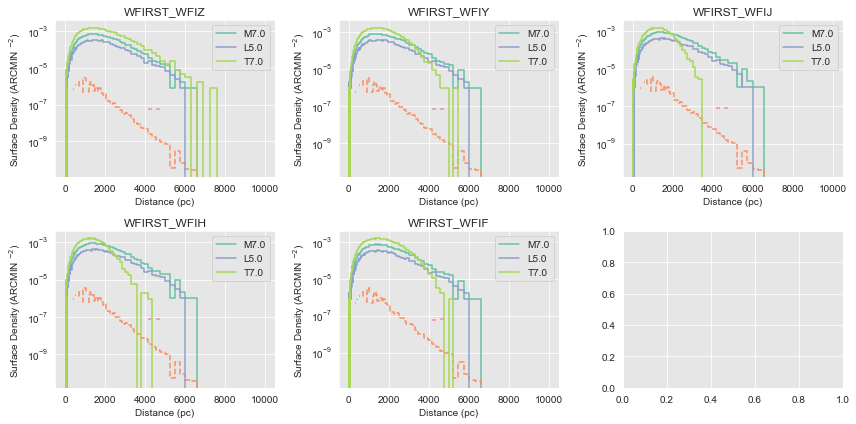

In [23]:
fig, ax=plt.subplots(2, 3, figsize=(12, 6))
df_cuts=[]
for k, a in zip(cuts.keys(), np.concatenate(ax)):
    df_cuts.append(number_counts_cut(k, a))
    #a.set_xscale('log')
    a.set_yscale('log')
    a.set_title(k)
    a.set_ylabel(r'Surface Density (ARCMIN $^{-2}$)')
    a.set_xlabel(r'Distance (pc)')
    a.legend()
plt.tight_layout()
plt.savefig(popsims.DATA_FOLDER+'/wfirst_distances.pdf')

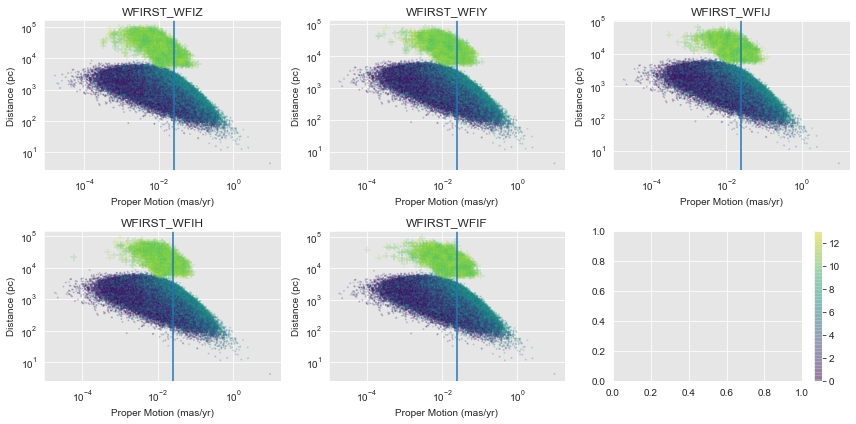

In [18]:
fig, ax=plt.subplots(2, 3, figsize=(12, 6))
for idx in np.arange(len(cuts.keys())):
    k=[x for x in cuts.keys()][idx]
    dffnn=df_cuts[idx][0]
    sd_dffnn=df_cuts[idx][1].sample(n=int(len(dffnn)*0.0051))
    a=np.concatenate(ax)[idx]
    c=a.scatter((dffnn.mu_alpha**2+dffnn.mu_delta**2)**0.5,
              dffnn.d, c=dffnn.age, 
              cmap='viridis', s=1, alpha=0.2, vmin=0, vmax=13)
    
    c=a.scatter((sd_dffnn.mu_alpha**2+sd_dffnn.mu_delta**2)**0.5,
              sd_dffnn.d, c=sd_dffnn.age, marker='+',
              cmap='viridis', s=50, alpha=0.2,  vmin=0, vmax=13)
    
    a.axvline(25*(10**-3))
    a.set_title(k)
    a.set_yscale('log')
    a.set_xlabel(r'Proper Motion (mas/yr)')
    a.set_ylabel(r'Distance (pc)')
    a.set_xscale('log')
    
plt.colorbar(c)
plt.tight_layout()

In [19]:
dffnn.columns

Index(['WFIRST_WFIJ', 'WFIRST_WFIY', 'WFIRST_WFIZ', 'WFIRST_WFIH',
       'WFIRST_WFIF', 'EUCLID_J', 'spt', 'teff', 'age', 'd', 'u', 'v', 'w',
       'rv', 'mu_alpha', 'mu_delta'],
      dtype='object')

Text(0, 0.5, 'Y-H')

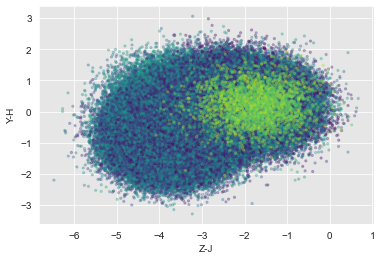

In [20]:
fig, ax=plt.subplots()

ax.scatter( dffnn.WFIRST_WFIZ-dffnn.WFIRST_WFIJ,
              dffnn.WFIRST_WFIY-dffnn.WFIRST_WFIH, c=dffnn.age, 
              cmap='viridis', s=5, alpha=0.3,vmin=0, vmax=13)

ax.scatter(sd_dffnn.WFIRST_WFIZ-sd_dffnn.WFIRST_WFIJ,
              sd_dffnn.WFIRST_WFIY-sd_dffnn.WFIRST_WFIH, c=sd_dffnn.age, 
              cmap='viridis', s=5, alpha=0.3, vmin=0, vmax=13)
plt.xlabel('Z-J')
plt.ylabel('Y-H')

Text(0.5, 0, '$V$')

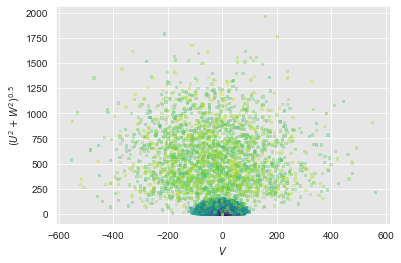

In [32]:
fig, ax=plt.subplots()

ax.scatter( dffnn.v, ( dffnn.w**2+dffnn.u**2)**0.5, c=dffnn.age, marker=',',
              cmap='viridis', s=5, alpha=0.3,vmin=0, vmax=13)

ax.scatter( sd_dffnn.v, ( sd_dffnn.w**2+sd_dffnn.u**2)**0.5, 
           c=sd_dffnn.age, marker=',',
              cmap='viridis', s=5, alpha=0.3,vmin=0, vmax=13)
plt.ylabel(r'$(U^2+W^2)^{0.5}$')
plt.xlabel(r'$V$')
#plt.xscale('log')
#plt.yscale('log')